# Feature Selection using Quantum Annealing
This notebook is based upon the D-Wave examples: https://github.com/dwave-examples/mutual-information-feature-selection

## Feature Selection: a brief Overview

Feature Selection is a problem in which you choose a subset of relevant and significant features from a larger set of features. The main goal of reducing the set of original features is to improve the model's performance.

However, there are other goals including:
- Decrease the effect of the Curse of Dimensionality: as the number of features increases, the amount of data needed to effectively cover the feature space grows exponentially.
- Decrease the Computational Complexity: training models with fewer features is computationally less expensive.
- Decrease the effect of Overfitting: irrelevant features can lead to overfitting, where the model performs well on the training data but poorly on new, unseen data.

## A little Background on Quantum Computing



Quantum Computing might sound like black magic for some people. In fact, we are employing sci-fi hardware to make very complex computations in a very small amount of time using qubits instead of bits.

But what is Quantum Computing in reality?

Quantum Computing is about leveraging Physics (Quantum Physics) to perform calculations. In particular, it exploits very small physical objects such as photons and their properties to directly solve a given problem instead of simulating it through a normal computer.

In other words, if we can map a problem into a physical system that follows the rules and principles of Quantum Physics, then we can directly employ quantum objects at our advantage to perform the specific computations needed.

## The Water Tank Example
Imagine you want to understand how water drains from a tank with a specific shape and size. The goal is to predict the time it takes for the tank to empty.

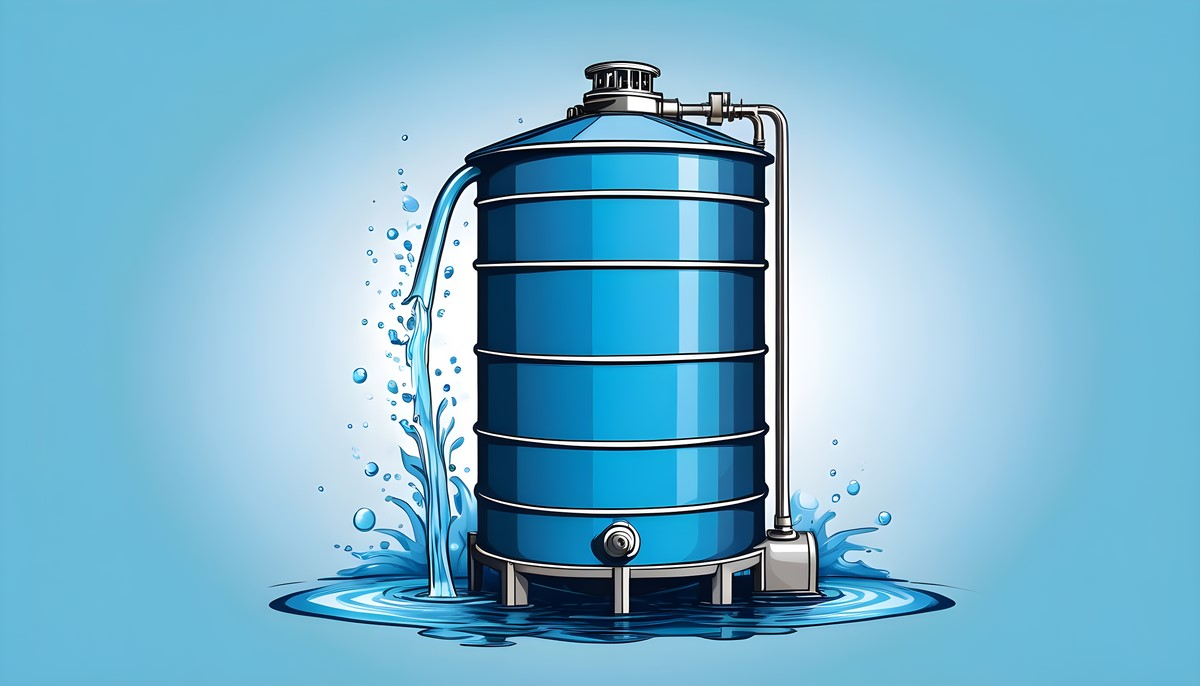



### Simulation with a Classical Computer
If we had to simulate this system, we would have to carry out the following steps:

1. Develop a detailed mathematical model of fluid dynamics for the given tank shape.
2. Implement numerical methods to solve the partial differential equations governing fluid flow, considering factors like viscosity, turbulence, and gravitational effects
3. Run one or possible many simulations of our system. Each simulation may take a **significant amount of time** to compute, especially for complex geometries and might require some approximations, thus making it very **hard to achieve accurate results** by accounting for all the intricate details of fluid behavior.

### Not Quantum Computing here but 'Fluid Computing'
Why not building the system itself and exploit the *computational power* of our fluid? Then we need to:

1. Construct a physical water tank with the exact geometry and parameters you want to study.
2. Fill the tank to a specific level and open the drain.
3. Measure the time it takes for the tank to empty. The time might be significantly lower with respect to the simulation. In addition, the physical water tank provides a direct, real-world demonstration of the draining process, capturing all fluid dynamics complexities inherently without needing to simulate them explicitly.


### Results
We report here the comparison of the 2 system described above:

- **Efficiency**: the physical system naturally incorporates the complexities of fluid dynamics without the need for extensive computational resources.
Running experiments with the physical tank is generally quicker than running simulations, especially for intricate geometries. In fact, the fluid dynamics simulation involves solving complex equations, and the computational cost increases with the complexity of the geometry and fluid properties.

- **Intuitiveness**: physical systems provide an intuitive understanding of the fluid behavior, allowing for direct observation and interaction.

- **Resource Savings**: constructing and conducting experiments with a physical tank can be resource-efficient compared to extensive computational simulations.

- **Effectiveness**: our physical system is likely to be more accurate since it might be possible that we have used approximations and heuristics to account for the complex operations involved in the simulation.


The computational power of our fluid is zero, but if the problem can be represented and mapped to it, then it becomes way more powerful than a classical computer!




## The Problem
Feature Selection is a **NP-HARD** problem that consists in selecting the optimal subset of features that maximizes the model performance.
Due to the problem complexity, the Feature Selection problem is usually solved through heuristics.

In this particular case, we want to consider an approach that is based on Mutual Information. The core idea is that we want to select the **most informative features** that can be used to train our learning model.

For this specific example, we will consider a simple toy dataset: the [Titanic dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset).

In this dataset we can find data about the Titanic passengers and we want to build a model that can predict whether a given passenger survived or not based on some specific features.



### Installing and Importing Packages
Download and use some packages to develop our quantum algorithms.

In [ ]:
!pip install dwave-system
!pip install dimod
!pip install dwave-neal
!pip install dwave-inspector
!pip install dwave-inspectorapp --extra-index=https://pypi.dwavesys.com/simple

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.dwavesys.com/simple


In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 89.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 39.3 MB/s eta 0:00:00


In [ ]:
import networkx as nx
from collections import defaultdict
from itertools import combinations
from dwave.system import DWaveCliqueSampler
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from neal import SimulatedAnnealingSampler
import math, dimod, itertools
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from qclef import qa_access as qa

Here we access the dataset through *pandas*. We also print how the dataset looks like. In particular, we have several features (14 features) and our target is represented by the **survided** column.
Now one question arises naturally... are all these features actually that useful for a predictor? Maybe we can just consider a subset of them to simplify the learning model and to boost efficiency while not impacting effectiveness.

In fact, in many cases real-world datasets contain hundreds (or even thousands) of features and some of them might not be useful at all (e.g., too noisy).

In [ ]:
# Access the dataset in my Drive folder
dataset = pd.read_csv("/config/workspace/datasets/formatted_titanic.csv")
dataset

,pclass,survived,sex,age,fare,cabin,miss,master,mr,mrs,rare,alone,embarked port S,embarked port C,embarked port Q
0,1,1,1,2,2,True,True,False,False,False,False,True,True,False,False
1,1,1,0,0,1,True,False,True,False,False,False,False,True,False,False
2,1,0,1,0,1,True,True,False,False,False,False,False,True,False,False
3,1,0,0,2,1,True,False,False,True,False,False,False,True,False,False
4,1,0,1,2,1,True,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,3,0,0,4,0,False,False,False,True,False,False,True,False,True,False
1041,3,0,1,0,0,False,True,False,False,False,False,False,False,True,False
1042,3,0,0,2,0,False,False,False,True,False,False,True,False,True,False
1043,3,0,0,2,0,False,False,False,True,False,False,True,False,True,False


Now we will see why Feature Selection is not so trivial.

Try to enumerate all the possible subsets of features having sizes from 1 to 14. There are actually $14!$ possible subsets, which is equivalent to $14!=87178291200$. This is a very huge number and it grows much more when we consider hundreds of features. Therefore, to understand which is the best subset of features we would be required to test all of these possible subsets which is probably infeasible due to time requirements...



Now, some of you could argue: "If we consider all the subset of $k$ features, then models trained on them will be at least as good as models trained on $k-1$ features. So why don't we choose $k$ such that the dataset is **small enough**?

This is a clever intuition, however the problem is still very complex. In fact, if we want to consider all the subsets having $k=10$ out of all the $n=14$ features, then we have to enumerate $n \choose k$ $=1001$ subsets which is still a very high number of subsets to test. And this number grows exponentially with the total number of features $n$.



Can Quantum Computing help us in this scenario? The answer is **YES**

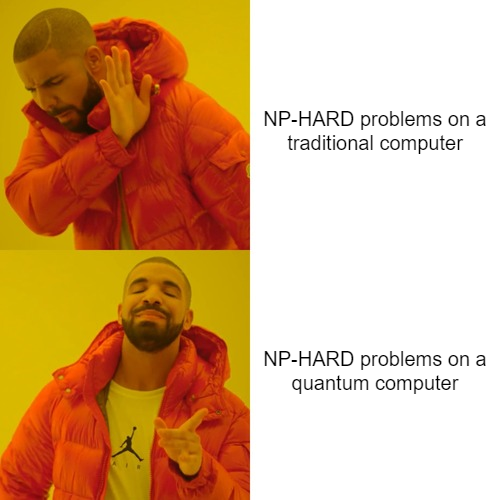

We can take advantage of the speedup that Quantum Computing brings us. In fact, through phenomena such as Superposition and Entanglement, Quantum Computing devices are able to explore problem spaces that grow exponentially with the number of available qubits.

So, 2 questions might naturally arise:

- Given a problem with $2^n$ possible solutions, can our quantum computer having $n$ qubits explore all the solutions in a *very* short time? **YES**
- Can our quantum computer return each of the possible $2^n$ solutions so that we can analyze them and maybe make some further considerations? **NO**

This might need a little bit more of explanation.


Imagine the Quantum Computer as a black box (a very cold one since it works at approximately -273 °C) where there is an input and an output. The input is obviously our problem and the output is the solution found.

We need to use it in this way! In fact, if we open it to *measure* the solution through the computation, we would break it completely: once we try to measure the computation, the qubits' states collapse. In fact, each qubit is in a very complex state during the computation but when we measure it, its state will be only $0$ or $1$.

Now that we have seen some interesting behaviours of Quantum Computing and that we have taken a look at our dataset, we shall continue with our exploration of Feature Selection using Quantum Annealing.

## MIQUBO: QUBO Representation of Feature Selection
D-Wave systems solve binary quadratic models (BQM)&mdash;the Ising model traditionally used in statistical mechanics and its computer-science equivalent, the quadratic unconstrained binary optimization (QUBO) problem. Given $N$ variables $x_1,...,x_N$, where each variable $x_i$ can have binary values $0$ or $1$, the system finds assignments of values that minimize,
    
$\sum_i^N q_ix_i + \sum_{i<j}^N q_{i,j}x_i  x_j$,
    
where $q_i$ and $q_{i,j}$ are configurable (linear and quadratic) coefficients. To formulate a problem for the D-Wave system is to program $q_i$ and $q_{i,j}$ so that assignments of $x_1,...,x_N$ also represent solutions to the problem.

For feature selection, the Mutual Information QUBO (MIQUBO) method formulates a QUBO based on the approximation above for $I({X_k}; Y)$, which can be submitted to the D-Wave quantum computer for solution.

The reduction of scope to permutations of three variables in this approximate formulation for MI-based optimal feature selection makes it a natural fit for reformulation as a QUBO:

|  | **Optimization** &nbsp; &nbsp; | **Linear <br>Terms** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |	**Quadratic <br>Terms** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| **Formula** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
|:-|:-----------------|:---------------------|:-------------------------|:------------|
| **Feature <br>Selection** &nbsp; &nbsp; | Maximize &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |$I(X_i;Y)$  | $I(X_j;Y \|X_i)$  | $\sum_{i \in S} \left \{ I(X_i;Y) + \sum_{j \in S, j \ne i} I(X_j;Y \|X_i) \right \}$ |
| **QUBO** | Minimize &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| $q_ix_i$ | $q_{i,j}x_ix_j$ | $\sum_i^N q_ix_i + \sum_{i<j}^N q_{i,j}x_i  x_j$ |

You can represent each choice of $n \choose k$ features as the value of solution $x_1,...,x_N$ by encoding $x_i=1$ if feature $X_i$ should be selected and $x_i=0$ if not. With solutions encoded this way, you can represent the QUBO in matrix format, $\mathbf{x}^T \mathbf{Q x}$, where $\mathbf Q$ is an $n$ x $n$ matrix and $\mathbf{x}$ is an $n$ x $1$ matrix (a vector) that should have $k$ ones representing the selected features.

To map the feature-selection formula to a QUBO, set the elements of $\mathbf Q$ such that

 * diagonal elements (linear coefficients) represent MI: $Q_{ii} \leftarrow -I(X_i;Y)$
 * non-diagonal elements (quadratic elements) represent CMI: $Q_{ij} \leftarrow -I(X_j;Y |X_i)$

These QUBO terms are negative because the quantum computer seeks to minimize the programmed problem while the feature-selection formula maximizes. The following subsection codes this and then completes the formulation by adding the $n \choose k$ constraint to the QUBO. 

There can be other formulations for the Feature Selection problem. You can find some more examples in this [paper](https://dl.acm.org/doi/abs/10.1145/3477495.3531755).

## Useful functions to compute Mutual Information
Here we define some functions that will be used to compute the Mutual Information and Conditional Mutual Information values that will define our problem. In particular, we provide here some useful definitions.

### Quantifying Information: Shannon Entropy
[Shannon entropy](https://en.wiktionary.org/wiki/Shannon_entropy), $H(X)$,  mathematically quantifies the information in a signal:

$H(X) = - \sum_{x \in X} p(x) \log p(x)$

where $p(x)$ represents the probability of an event's occurrence. The Shannon Entropy (SE) formula can be understood as weighing by an event's probability a value of $\log \frac{1}{p(x)}$ for the event, where the reciprocal is due to the minus sign. This value means that the less likely the occurrence of an event, the more information is attributed to it (intuitively, when a man bites a dog it's news).


### Conditional Shannon Entropy

Conditional SE (CSE) measures the information in one signal, $X$, when the value of another signal, $Y$, is known:

$\begin{aligned} H(X|Y)
& = H(X,Y)-H(Y) \\
& = - \sum_{x \in X} p(x, y) \log p(x, y) - H(Y) \end{aligned}$

where joint SE, $H(X,Y)$, measures the information in both signals together, with $p(x,y)$ being their joint probability. For example, knowing that it's winter reduces the information value of news that it is raining.  

### Mutual Information
[Mutual information](https://en.wikipedia.org/wiki/Mutual_information) between variables $X$ and $Y$ is defined as

$I(X;Y)  = \sum_{y \in Y} \sum_{x \in X} p(x, y) \log \frac{p(x,y)}{p(x)p(y)}$

where $p(x)$ and $p(y)$ are marginal probabilities of $X$ and $Y$, and $p(x,y)$ the joint probability. Equivalently,

$I(X;Y)  = H(Y) - H(Y|X)$

where $H(Y)$ is the SE of $Y$ and $H(Y|X)$ is the CSE of $Y$ conditional on $X$.

Mutual information (MI) quantifies how much one knows about one random variable from observations of another. Intuitively, a model based on just one of a pair of features (e.g., farmer MacDonald's water rations and soil humidity) will better reproduce their combined contribution when MI between them is high.

A high mutual information value implies strong dependence or correlation between the variables, meaning that knowledge of one variable provides a lot of information about the other variable. On the other hand, a low or zero mutual information value indicates little or no association between the variables

### Conditional Mutual Information

Conditional mutual information (CMI) between a variable of interest, $X$, and a feature, $Y$, given the selection of another feature, $Z$, is given by

$I(X;Y|Z) = H(X|Z)-H(X|Y,Z)$

where $H(X|Z)$ is the CSE of $X$ conditional on $Z$ and $H(X|Y, Z)$ is the CSE of $X$ conditional on both $Y$ and $Z$.

A high conditional mutual information value implies strong dependence or correlation between variables $X$ and $Y$ given the value of variable $Z$. It indicates that knowledge of variable $Z$ provides significant information about the relationship between variables $X$ and $Y$. Conversely, a low or zero conditional mutual information value suggests little or no association between variables $X$ and $Y$ given the value of variable $Z$


In [ ]:
def shannon_entropy(p):
    """Shannon entropy H(X) is the negative sum of P(X)log(P(X)) for probability
    distribution P(X).
    """
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)


def conditional_shannon_entropy(p, *conditional_indices):
    """Conditional Shannon entropy H(X|Y) = H(X,Y) - H(Y)."""

    # Sanity check on validity of conditional_indices.  In particular,
    # try to trap issues in which dimensions have been removed from
    # probability table through marginalization, but
    # conditional_indices were not updated accordingly.
    assert(all(ci < p.ndim for ci in conditional_indices))

    axis = tuple(i for i in np.arange(len(p.shape))
                 if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))


def mutual_information(prob, j):
    """Mutual information between variables X and variable Y.
    Calculated as I(X; Y) = H(X) - H(X|Y)."""

    return (shannon_entropy(np.sum(prob, axis=j))
            - conditional_shannon_entropy(prob, j))


def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z.
    Calculated as I(X;Y|Z) = H(X|Z) - H(X|Y,Z)"""

    # Compute an updated version of the conditional indices for use
    # when the probability table is marginalized over dimension j.
    # This marginalization removes one dimension, so any conditional
    # indices pointing to dimensions after this one must be adjusted
    # accordingly.
    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))


def prob(dataset):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [len(np.unique(dataset[:, ci])) for ci in range(num_columns)]

    prob, _ = np.histogramdd(dataset, bins)
    return prob / np.sum(prob)


def mutual_information_bqm(dataset, features, target):
    """Builds the BQM according to Mutual Information and
    Conditional Mutual Information"""
    BQM = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for f_label in features:
        f_MI = mutual_information(prob(dataset[[target, f_label]].values), 1)

        BQM.add_variable(f_label, -f_MI)

    for f1_label, f2_label in itertools.permutations(features, 2):
        f_CMI = conditional_mutual_information(prob(dataset[[target, f1_label, f2_label]].values), 1, 2)

        BQM.add_interaction(f1_label, f2_label, -f_CMI)

    return BQM


def maximum_energy_delta(bqm):
    """Compute conservative bound on maximum change in energy when flipping a single variable"""
    return max(abs(bqm.get_linear(i))
               + sum(abs(bqm.get_quadratic(i,j))
                     for j in bqm.iter_neighbors(i))
               for i in bqm.iter_variables())


def print_response_data(response):
    """Custom function to display the response data in a clear way"""
    print('-' * 65)
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy',"Count"))
    print('-' * 65)
    for sample, E, occ in response.data(fields=['sample','energy',"num_occurrences"]):
        S0 = [k for k,v in sample.items() if v == 0]
        S1 = [k for k,v in sample.items() if v == 1]
        print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(occ)))

## Mutual Information between each Feature and the Target
Here we provide a simple plot showing the Mutual Information values between each one of the 14 features and the **survived** feature.

{'pclass': 0.07475277173067907, 'age': 0.005856173464142689, 'master': 0.0022420218792443825, 'embarked port C': 0.03431208876301217, 'alone': 0.030893918713272184, 'miss': 0.06425980788011365, 'cabin': 0.07088477290688078, 'rare': 2.0483711632046653e-05, 'sex': 0.21538389402117208, 'embarked port Q': 0.003495746730361904, 'mr': 0.21729321954570802, 'fare': 0.01230075270972833, 'mrs': 0.09716723053142817, 'embarked port S': 0.02188782688711921}


<BarContainer object of 14 artists>

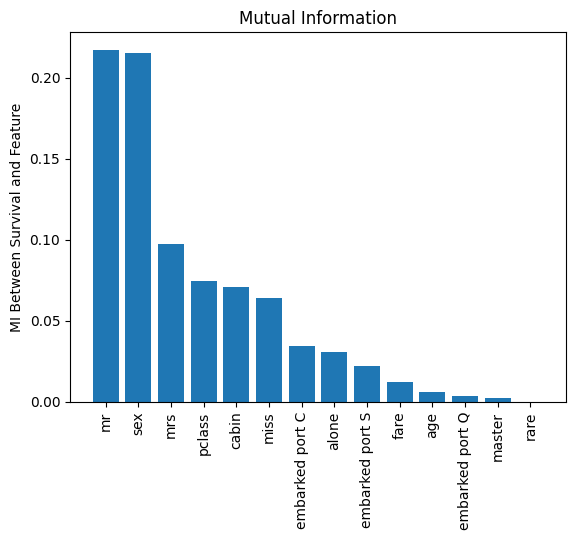

In [ ]:
# Our target feature
target = "survived"

feature_mutual_information = {feature: mutual_information(prob(dataset[[target, feature]].values), 0)
                              for feature in set(dataset.columns) - {target}}
print(feature_mutual_information)
labels, values = zip(*sorted(feature_mutual_information.items(), key=lambda pair: pair[1], reverse=True))

# Plot the MI between the 'survived' feature and every other
plt.figure()
ax1 = plt.subplot(1, 1, 1)
ax1.set_title("Mutual Information")
ax1.set_ylabel('MI Between Survival and Feature')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.bar(np.arange(len(labels)), values)

Here we plot the features with their corresponding Mutual Information values, sorted from highest to lowest.

In [ ]:
sorted_scores = sorted(feature_mutual_information.items(), key=lambda pair: pair[1], reverse=True)
dataset = dataset[[column[0] for column in sorted_scores] + ["survived"]]
features = sorted(list(set(dataset.columns) - {target}))
sorted_scores

[('mr', 0.21729321954570802),
 ('sex', 0.21538389402117208),
 ('mrs', 0.09716723053142817),
 ('pclass', 0.07475277173067907),
 ('cabin', 0.07088477290688078),
 ('miss', 0.06425980788011365),
 ('embarked port C', 0.03431208876301217),
 ('alone', 0.030893918713272184),
 ('embarked port S', 0.02188782688711921),
 ('fare', 0.01230075270972833),
 ('age', 0.005856173464142689),
 ('embarked port Q', 0.003495746730361904),
 ('master', 0.0022420218792443825),
 ('rare', 2.0483711632046653e-05)]

Here it is represented our QUBO matrix through a color map. As it is possible to see, the matrix is triangular.

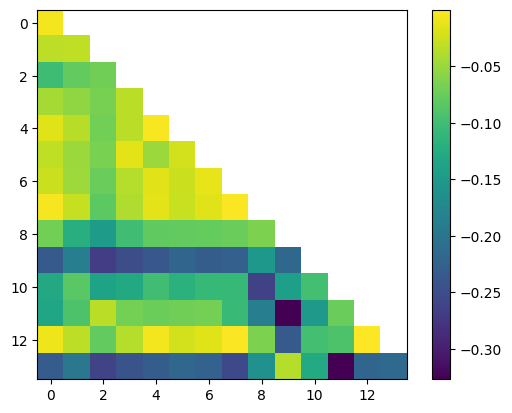

In [ ]:
# Build our problem
bqm = mutual_information_bqm(dataset, features, target)

# Represent our QUBO matrix
Q_np = np.ones((len(features),len(features)))*np.nan

feature_to_index = {feature:index for index,feature in enumerate(features)}

for (i,j),value in bqm.to_qubo()[0].items():
    i = feature_to_index[i]
    j = feature_to_index[j]

    Q_np[i,j] = value

plt.imshow(Q_np, cmap='viridis')
plt.colorbar()

### A small observation
The Titanic dataset provides a familiar, intuitive example available in the public domain. In itself, however, it is not a good fit for solving by sampling. Run naively on this dataset, it finds numerous good solutions but is unlikely to find the exact optimal solution.
There are many techniques for reformulating problems for the D-Wave system that can improve performance on various metrics, some of which can help narrow down good solutions to closer approach an optimal solution.
This demo solves the problem for just the highest-scoring features.

## Running with Simulated Annealing first
Here we use the Simulated Annealing algorithm, which is an algorithm that works without a Quantum Computer. In fact, everything is computed on our classical CPU but the problem is set up as if it was to be deployed on a Quantum Processing Unit (QPU).

Simulated Annealing does not guarantee to retrieve the optimal solution, it is still a sort of heuristic.

In [ ]:
# Set up a QPU sampler that embeds to a fully-connected graph of all the variables
sampler = SimulatedAnnealingSampler()
num_reads = 2000

response_SA=qa.submit(sampler,
    SimulatedAnnealingSampler.sample,
    bqm,
    label='3 Tutorial - MI Feature Selection',
    num_reads=num_reads
)

#response_SA = sampler.sample(bqm,
#                        label='Example - MI Feature Selection',
#                        num_reads=num_reads)

In [ ]:
print_response_data(response_SA.aggregate())

-----------------------------------------------------------------
          Set 0          Set 1    Energy          Count     
-----------------------------------------------------------------
             []['age', 'alone', 'cabin', 'embarked port C', 'embarked port Q', 'embarked port S', 'fare', 'master', 'miss', 'mr', 'mrs', 'pclass', 'rare', 'sex']-10.840134854618814     2000      


## We always selected all the features...

How do you program  on the quantum computer a constraint that exactly $k$ features be selected? By penalizing solutions that select greater or fewer than $k$ features. If you add

$P = \alpha (\sum_{i=1}^n x_i - k)^2$

to the QUBO, where penalty $P$ is positive whenever the number of $1$s in solution $x_1,...,x_N$ is not $k$, a large enough $\alpha$ can ensure that such solutions are no longer minima of the problem.  


In [ ]:
# The number of features to keep
k = 4

# This ensures that the solution will satisfy the constraints. It represents our 'alpha'
penalty = maximum_energy_delta(bqm)

# For each number of features, k, penalize selection of fewer or more features
kbqm = dimod.generators.combinations(bqm.variables, k, strength=penalty)
kbqm.update(bqm)

response_SA_4=qa.submit(sampler,
    SimulatedAnnealingSampler.sample,
    kbqm,
    label='3 Tutorial - MI Feature Selection',
    num_reads=num_reads
)


/tmp/ipykernel_55450/975596991.py:81: UserWarning: bqm.iter_variables() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use iter(bqm.variables) instead.
  for i in bqm.iter_variables())
/tmp/ipykernel_55450/975596991.py:79: DeprecationWarning: bqm.iter_neighbors(u) is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use (v for v, _ in bqm.iter_neighborhood(u)) instead.
  + sum(abs(bqm.get_quadratic(i,j))


Here we represent once again the QUBO matrix but this time we consider also the opportune penalties used to make our model choose $k$ features.

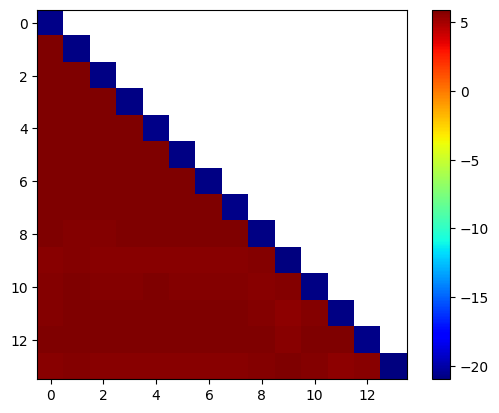

In [ ]:
Q_np = np.ones((len(features),len(features)))*np.nan

feature_to_index = {feature:index for index,feature in enumerate(features)}

for (i,j),value in kbqm.to_qubo()[0].items():
    i = feature_to_index[i]
    j = feature_to_index[j]

    Q_np[i,j] = value

plt.imshow(Q_np, cmap='jet')
plt.colorbar()

In [ ]:
print_response_data(response_SA_4.aggregate())

-----------------------------------------------------------------
          Set 0          Set 1    Energy          Count     
-----------------------------------------------------------------
['age', 'alone', 'embarked port C', 'embarked port Q', 'embarked port S', 'fare', 'master', 'miss', 'mrs', 'rare']['cabin', 'mr', 'pclass', 'sex']-1.8303089253340232       5       
['alone', 'cabin', 'embarked port C', 'embarked port Q', 'embarked port S', 'fare', 'master', 'miss', 'mrs', 'rare']['age', 'mr', 'pclass', 'sex']-1.8050306785116916       9       
['age', 'alone', 'cabin', 'embarked port Q', 'embarked port S', 'fare', 'master', 'miss', 'mrs', 'rare']['embarked port C', 'mr', 'pclass', 'sex']-1.793102044426604       4       
['age', 'alone', 'cabin', 'embarked port C', 'embarked port Q', 'embarked port S', 'fare', 'miss', 'mrs', 'rare']['master', 'mr', 'pclass', 'sex']-1.7863819392127098       8       
['age', 'alone', 'cabin', 'embarked port C', 'embarked port Q', 'embarked port S', '

## Once again but with Quantum Annealing
Now we will use Quantum Annealing for real. This works as follows:
1. We need to have an API KEY which is required to have access to D-Wave's infrastructure.
2. Once we create our sampler and submit our problem, we will send it through internet. The problem will reach the D-Wave's infrastructure and will be enqued if there are currently other problems running.
3. Once it is our turn, our problem will be solved and the solution will be sent back to us.

You can use different solvers (i.e., different quantum annealers) when submitting your own problem. By default, the choice is the D-Wave Advantage having the *pegasus* topology with more than 5000 qubits which is currently the most powerful one.

It is also possible to consider other solvers as follows:
```python
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'zephyr'})) # Choose Advantage
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'})) # Choose DW_2000Q
sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'pegasus'})) # Choose Advantage 2
```

There are also other parameters that can be set. The entire list is can be seen with
```python
sampler = DWaveSampler(solver={'topology__type': 'zephyr'})
print(sampler.parameters)
```

In [ ]:
import dwave.inspector

In [ ]:
sampler=EmbeddingComposite(DWaveSampler())

response_QPU_4=qa.submit(sampler,
    EmbeddingComposite.sample,
    kbqm,
    label='3 Tutorial - MI Feature Selection',
    num_reads=num_reads
)

In [ ]:
print_response_data(response_QPU_4.aggregate())

-----------------------------------------------------------------
          Set 0          Set 1    Energy          Count     
-----------------------------------------------------------------
['age', 'alone', 'embarked port C', 'embarked port Q', 'embarked port S', 'fare', 'master', 'miss', 'mrs', 'rare']['cabin', 'mr', 'pclass', 'sex']-1.8303089253340143       2       
['alone', 'cabin', 'embarked port C', 'embarked port Q', 'embarked port S', 'fare', 'master', 'miss', 'mrs', 'rare']['age', 'mr', 'pclass', 'sex']-1.8050306785116668       4       
['age', 'alone', 'cabin', 'embarked port Q', 'embarked port S', 'fare', 'master', 'miss', 'mrs', 'rare']['embarked port C', 'mr', 'pclass', 'sex']-1.7931020444266004       7       
['age', 'alone', 'cabin', 'embarked port C', 'embarked port Q', 'embarked port S', 'fare', 'miss', 'mrs', 'rare']['master', 'mr', 'pclass', 'sex']-1.7863819392126974       3       
['age', 'alone', 'cabin', 'embarked port C', 'embarked port Q', 'embarked port S', 

In [ ]:
print(response_QPU_4.info)

{'timing': {'qpu_sampling_time': 169680.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 44.26, 'qpu_access_time': 185439.97, 'qpu_access_overhead_time': 1744.03, 'qpu_programming_time': 15759.97, 'qpu_delay_time_per_sample': 20.58, 'total_post_processing_time': 1.0, 'post_processing_overhead_time': 1.0}, 'problem_id': '9c5db31f-ffc6-4011-972f-064da69c7d8b', 'problem_label': '10 Tutorial - MI Feature Selection'}


## Problem Inspection
You might have noticed that we imported the **dwave.inspector** package a few lines above. This is because we want to see how the problem has been physically embedded in the Quantum Processing Unit (QPU).

In fact, the D-Wave Inspector tool allows us to have a very comprehensive understanding of how the variables have been mapped to the qubits available in the QPU. In addition, we can have more details regarding the overall submission (e.g., the presence of some warnings, the histogram reporting the energy levels associated to the retrieved solutions,...).

To visualize the embedded problem one can just call the function:

```python
dwave.inspector.show(sampleset)
```
providing as **sampleset** the set of samples that represent the solutions retrieved for a given submitted problem.

In [ ]:
dwave.inspector.show(response_QPU_4)

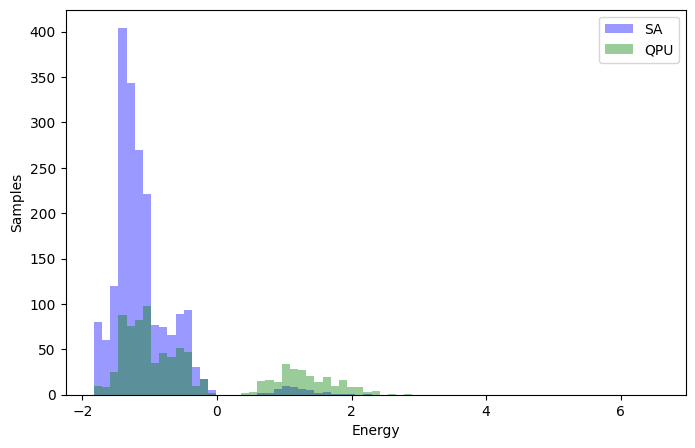

In [ ]:
num_bins = 100
use_bin = 70

def histogram_energies(sampleset_SA, sampleset_QPU):
    "Plot energy histograms for both QPUs."

    fig = plt.figure(figsize=(8, 5))
    SA = sampleset_SA.record.energy
    QPU = sampleset_QPU.record.energy

    bins=np.histogram(np.hstack((SA,QPU)), bins=num_bins)[1]

    ax = fig.add_subplot(1, 1, 1)

    ax.hist(SA, bins[0:use_bin], color='b', alpha=0.4, label="SA")
    ax.hist(QPU, bins[0:use_bin], color='g', alpha=0.4, label="QPU")

    ax.set_xlabel("Energy")
    ax.set_ylabel("Samples")
    ax.legend()
    plt.show()

histogram_energies(response_SA_4, response_QPU_4)

## A very simple comparison
Here we compare the subsets obtained through Quantum Annealing and the ones that previously had the maximum values for Mutual Information.

We briefly train a Random Forest Classifier and we can see its performance after training.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
X=dataset.drop(columns='survived')
y=np.array(dataset[['survived']])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

The accuracy of the Random Forest Classifier on the features extracted through Quantum Annealing.

In [ ]:
features_qa=response_QPU_4.first.sample
features_kept_qa=[]
for feature in features_qa.keys():
    if(features_qa[feature]>0):
        features_kept_qa.append(feature)

X_train_qa=X_train[features_kept_qa]
X_test_qa=X_test[features_kept_qa]

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = clf.fit(X_train_qa, y_train.ravel())
score=clf.score(X_test_qa,y_test)
score

0.7177033492822966

The accuracy of the Random Forest Classifier on the features that had the highest Mutual Information values (*mr*, *sex*, *mrs*, *pclass*).

In [ ]:
features_kept_max=[]
for i in range(k):
    features_kept_max.append(sorted_scores[i][0])

X_train_max=X_train[features_kept_max]
X_test_max=X_test[features_kept_max]

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = clf.fit(X_train_max, y_train.ravel())
score=clf.score(X_test_max,y_test)
score

0.7033492822966507

## How to submit the final set of features

In [ ]:
dataset = pd.read_csv("/config/workspace/datasets/formatted_titanic.csv")

filename="/submissions/feature_selection.txt"

target="survived"
features = list(set(dataset.columns) - {target})
bqm = mutual_information_bqm(dataset, features, target)

# The number of features to keep
k = 4

# This ensures that the solution will satisfy the constraints. It represents our 'alpha'
penalty = maximum_energy_delta(bqm)

# For each number of features, k, penalize selection of fewer or more features
kbqm = dimod.generators.combinations(bqm.variables, k, strength=penalty)
kbqm.update(bqm)

sampler=EmbeddingComposite(DWaveSampler())

response_QPU_4=qa.submit(sampler,
    EmbeddingComposite.sample,
    kbqm,
    label='3 Tutorial - MI Feature Selection',
    num_reads=num_reads
)

best_solution=response_QPU_4.first.sample

features_to_keep=[]
for feature,selected in best_solution.items():
    if(selected==1):
        features_to_keep.append(feature)

submission=""
for i,feature in enumerate(features_to_keep):
    if(i==len(features_to_keep)-1):
        submission+=str(feature)
    else:
        submission+=str(feature)+"\n"

